# 读取数据

In [1]:
import pickle
road_zip={}
orthogonal_list={}
node_dict={}
node_dict_amap={}
way_list=[]
with open('../data/road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)
with open('../data/map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('../data/map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('../data/graph.pkl','rb') as f:
    orthogonal_list=pickle.load(f)
with open('../data/map_ways.pkl','rb') as f:
    way_list=pickle.load(f)
way_vertex_list=[]
for way in way_list:
    vertex_list=[]
    for node in way[1]:
        if node in orthogonal_list:
            vertex_list.append(node)
    if len(vertex_list)>0:
        way_vertex_list.append((way[0],vertex_list))
way_vertex_dict={}
for way in way_vertex_list:
    if way[0] not in way_vertex_dict:
        way_vertex_dict[way[0]]=way[1]
    else:
        way_vertex_dict[way[0]].extend(way[1])
for way in way_vertex_dict:
    way_vertex_dict[way]=list(set(way_vertex_dict[way]))
node_id2no={Id:No for No,Id in enumerate(orthogonal_list)}
node_no2id={No:Id for No,Id in enumerate(orthogonal_list)}

class edge_item:
    def __init__(self,vi,vj):
        self.position=(vi,vj)
        self.exist=False
        self.rname=''
        self.roads=[]
    
adj_matrix={vi:{vj:edge_item(vi,vj) for vj in orthogonal_list} for vi in orthogonal_list}
for key,value in orthogonal_list.items():
    vi=key
    edges=value[0]+value[1]
    for edge in edges:
        vj=edge[1]
        adj_matrix[vi][vj].exist=True
        adj_matrix[vi][vj].rname=edge[0]

# 将高德路段与拓扑图对应

In [2]:
#从道路方向信息中解析出道路的起讫点
def decodeDirection(direction):
    begin,end='',''
    if direction[0]=='从':
        strlist=direction.split('到')
        begin=strlist[0][1:]
        end=strlist[1]
    elif direction[-2:]=='附近':
        begin=direction[:-2]
        end=direction[:-2]
    return begin,end
def findRelatedEdges(name,s,d):
    sv_list,dv_list=[],[]
    for v in way_vertex_dict[name]:
        for e in adj_matrix[v].values():
            if e.exist and e.rname==s:
                sv_list.append(v)
            if e.exist and e.rname==d:
                dv_list.append(v)

    related_edges=[]
    #能找到起讫点
    if len(sv_list)>0 and len(dv_list)>0:
        route=[]
        for sv in sv_list:
            history_v=[sv]
            answer_v=[]
            next_seq=[[sv]]
            while len(next_seq)>0:
                seq=next_seq.pop()
                v=seq[-1]
                for e in adj_matrix[v].values():
                    if e.exist and e.rname==name and e.position[1] not in history_v:
                        history_v.append(e.position[1])
                        if e.position[1] in dv_list:
                            answer_v.append(seq+[e.position[1]])
                        else:
                            next_seq.append(seq+[e.position[1]])
            route.extend(answer_v)
        if len(route)==0:
            print(name,s,d,'有起讫点但找不到路径')
            # 则将所有路段纳入相关边
            for vi in way_vertex_dict[name]:
                for vj,e in adj_matrix[vi].items():
                    if e.exist and e.rname==name:
                        if node_id2no[vi]<=node_id2no[vj] and (vi,vj) not in related_edges:
                            related_edges.append((vi,vj))
                        elif node_id2no[vi]>node_id2no[vj] and (vj,vi) not in related_edges:
                            related_edges.append((vj,vi))
                        
        for rt in route:
            for i in range(1,len(rt)):
                vi,vj=rt[i-1],rt[i]
                if node_id2no[vi]<=node_id2no[vj] and (vi,vj) not in related_edges:
                    related_edges.append((vi,vj))
                elif node_id2no[vi]>node_id2no[vj] and (vj,vi) not in related_edges:
                    related_edges.append((vj,vi))
    #找不到起讫点，则将所有路段纳入相关边
    else:
        for vi in way_vertex_dict[name]:
            for vj,e in adj_matrix[vi].items():
                if e.exist and e.rname==name:
                    if node_id2no[vi]<=node_id2no[vj] and (vi,vj) not in related_edges:
                        related_edges.append((vi,vj))
                    elif node_id2no[vi]>node_id2no[vj] and (vj,vi) not in related_edges:
                        related_edges.append((vj,vi))
    if len(related_edges)==0:
        print('error')
    return related_edges

In [3]:
roads=list(road_zip.keys())
road_edges={}
for road in roads:
    if road[0] in way_vertex_dict:
        begin,end=decodeDirection(road[1])
        related_edges=findRelatedEdges(road[0],begin,end)
        if len(related_edges)>0:
            road_edges[road]=related_edges

for road,edges in road_edges.items():
    for edge in edges:
        vi,vj=edge[0],edge[1]
        adj_matrix[vi][vj].roads.append(road)
spatial_maps=adj_matrix

金桥路 龙东大道 浦东大道 有起讫点但找不到路径
北艾路 高科西路 杨高南路 有起讫点但找不到路径
同普路 泾阳路 中江路 有起讫点但找不到路径
同普路 中江路 泾阳路 有起讫点但找不到路径
五莲路 浦东大道 双桥路 有起讫点但找不到路径
五莲路 双桥路 东陆路 有起讫点但找不到路径
双桥路 金高路 张杨北路 有起讫点但找不到路径
齐河路 杨高南路 云台路 有起讫点但找不到路径
北艾路 杨高南路 高科西路 有起讫点但找不到路径
江场路 奎照路 粤秀路 有起讫点但找不到路径
江场路 粤秀路 奎照路 有起讫点但找不到路径
通耀路 耀龙路 世博馆路 有起讫点但找不到路径
通耀路 世博馆路 耀龙路 有起讫点但找不到路径
万源路 漕宝路 虹中路 有起讫点但找不到路径
万源路 虹中路 漕宝路 有起讫点但找不到路径
浦三路 临沂路 永泰路 有起讫点但找不到路径
国权路 黄兴路 四平路 有起讫点但找不到路径
政民路 武东路 淞沪路 有起讫点但找不到路径
政民路 淞沪路 武东路 有起讫点但找不到路径
武川路 纪念路 政立路 有起讫点但找不到路径
武川路 政立路 纪念路 有起讫点但找不到路径
五莲路 双桥路 浦东大道 有起讫点但找不到路径
梅川路 祁连山南路 兰溪路 有起讫点但找不到路径
梅川路 兰溪路 祁连山南路 有起讫点但找不到路径
丰庄路 金沙江路 曹安公路 有起讫点但找不到路径
丰庄路 曹安公路 金沙江路 有起讫点但找不到路径
浦三路 临沂路 成山路 有起讫点但找不到路径
武胜路 黄陂北路 西藏中路 有起讫点但找不到路径
东三里桥路 杨高南路 南码头路 有起讫点但找不到路径
东三里桥路 南码头路 杨高南路 有起讫点但找不到路径
芙蓉江路 虹古路 长宁路 有起讫点但找不到路径
芙蓉江路 长宁路 虹古路 有起讫点但找不到路径
西藏北路 西藏中路 柳营路 有起讫点但找不到路径
西藏北路 柳营路 西藏中路 有起讫点但找不到路径
江宁路 南京西路 光复西路 有起讫点但找不到路径
江宁路 光复西路 南京西路 有起讫点但找不到路径
虬江路 四川北路 四川北路 有起讫点但找不到路径
银城中路 东昌路 浦东南路 有起讫点但找不到路径
银城中路 浦东南路 东昌路 有起讫点但找不到路径
中兴路 交通路 华昌路 有起讫点但找不到路径
中兴路 华昌路 交通路 有起讫点但找不到路径
南泉北路 浦东大道 张

In [4]:
import pickle
with open('../data/road_edges.pkl','wb') as f:
    pickle.dump(road_edges,f)

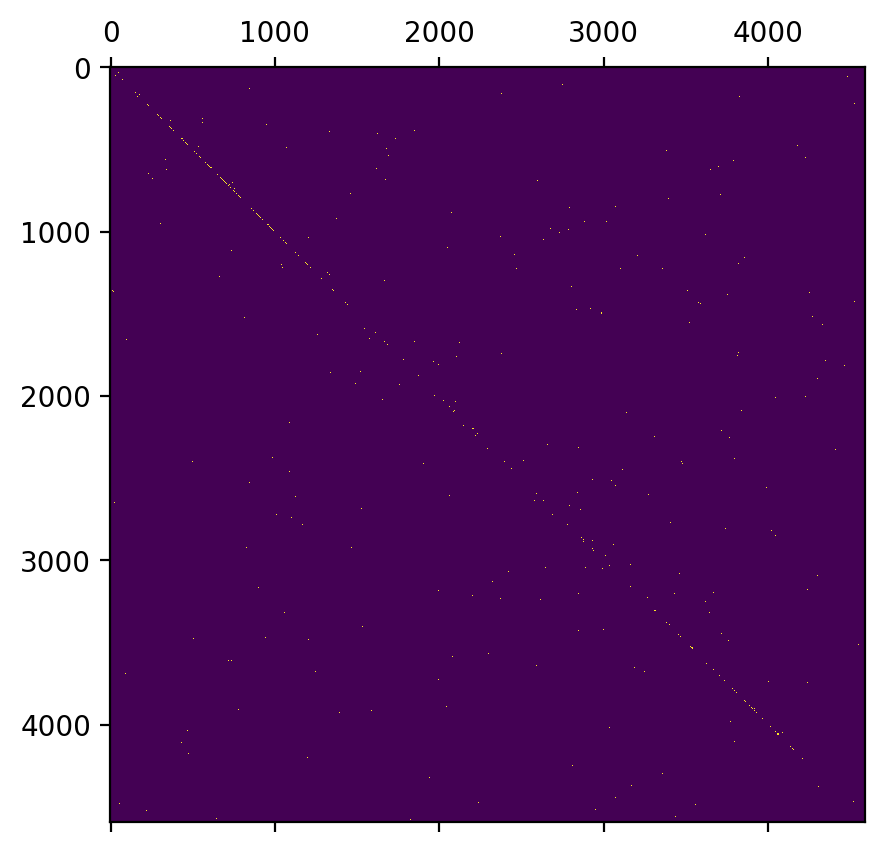

In [5]:
import numpy as np
matrix=[[0 for _ in range(len(spatial_maps))] for _ in range(len(spatial_maps))]
for i in range(len(spatial_maps)):
    for j in range(len(spatial_maps)):
        if spatial_maps[node_no2id[i]][node_no2id[j]].exist:
            matrix[i][j]=1
# 绘制矩阵            
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.matshow(matrix)
fig.show()

绘制匹配路段图

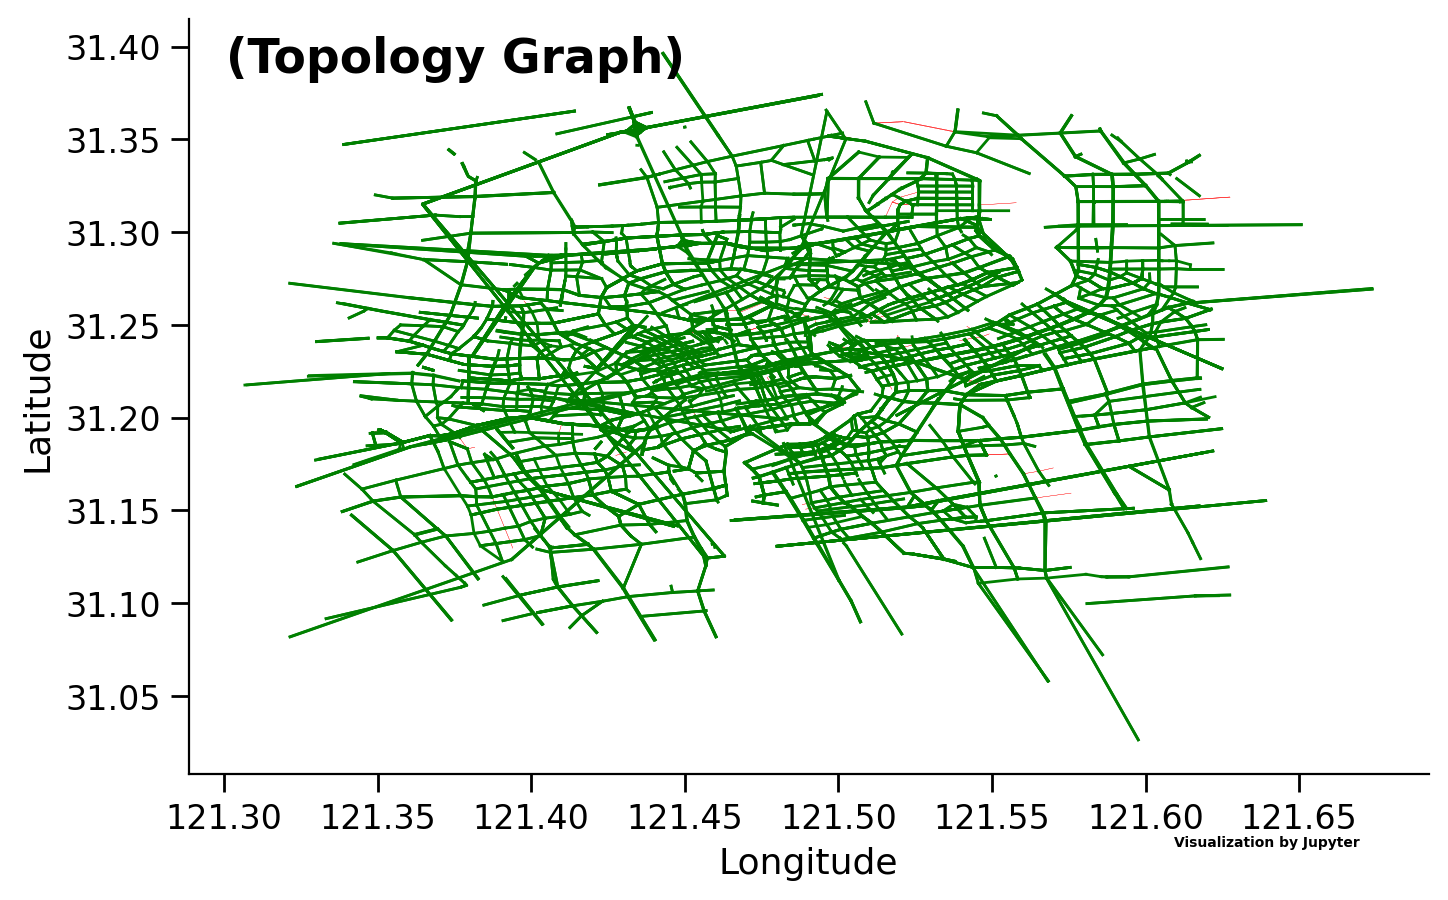

In [5]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for vi in spatial_maps:
    for vj,e in spatial_maps[vi].items():
        if e.exist:
            ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color='r',linewidth=.1)
for road,edges in road_edges.items():
    for edge in edges:
        vi,vj=edge[0],edge[1]
        ax.plot([float(ref[vi][0]),float(ref[vj][0])],[float(ref[vi][1]),float(ref[vj][1])],color='g',linewidth=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Topology Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()